In [1]:
# --- Step 1: Import Libraries ---

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Set plot style
plt.style.use('fivethirtyeight')

Fetching maximum available hourly data for ADBE (730d)...


C:\Users\INDIA\AppData\Local\Temp\ipykernel_8580\3250369997.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval=interval, progress=False)


Data fetched successfully. Original shape: (5081, 5) -> After dropna: (5081, 5)


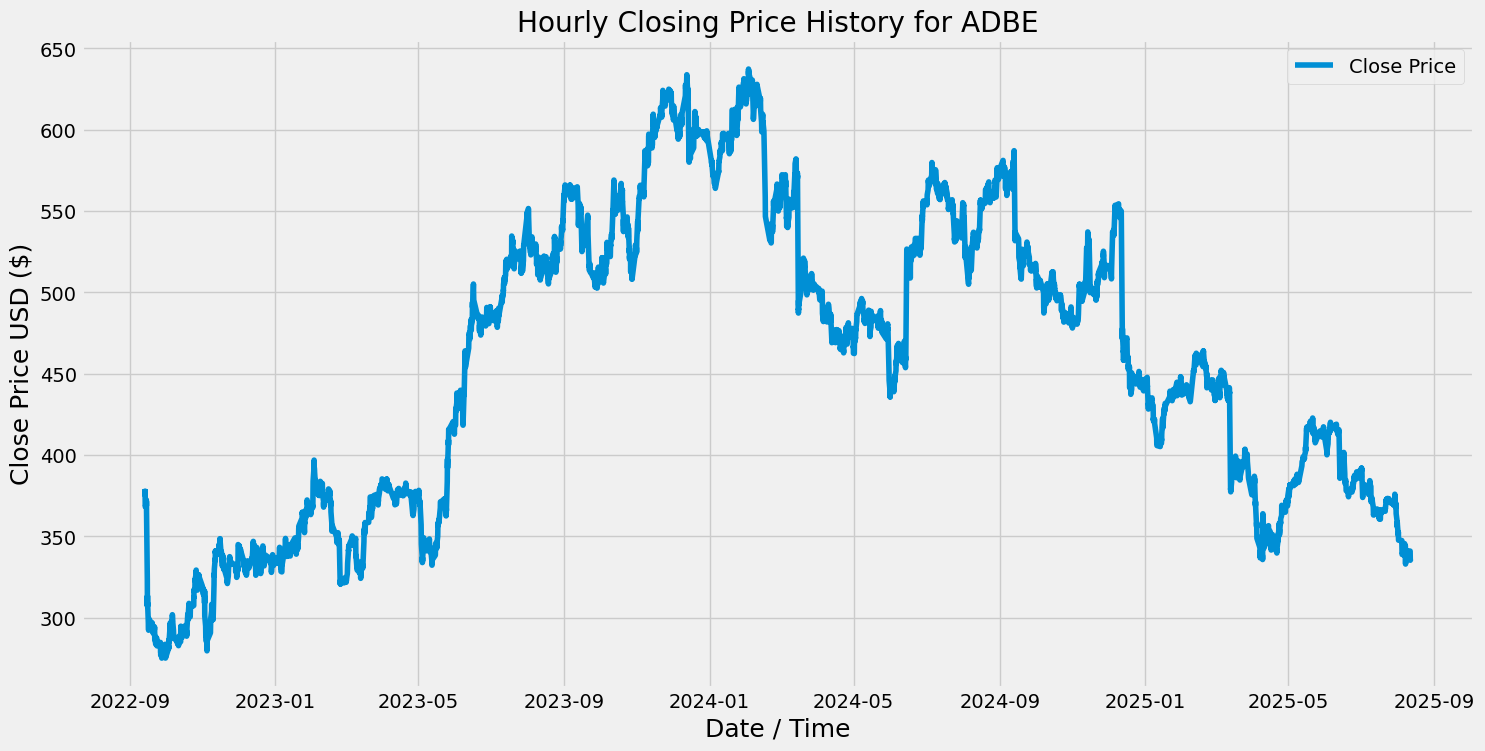

Preprocessing complete. Ready for model building/training.


In [2]:
# --- Combined Cell: Safe Fetch, Verify, and Preprocess Data ---

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Config
TICKER = 'ADBE'
PERIOD = "730d"
INTERVAL = "1h"
TIME_STEP = 60

print(f"Fetching maximum available hourly data for {TICKER} ({PERIOD})...")

def safe_fetch(ticker, period, interval):
    try:
        df = yf.download(ticker, period=period, interval=interval, progress=False)
    except Exception as e:
        raise RuntimeError(f"Download failed for {ticker}: {e}")

    if df.empty:
        raise ValueError(f"No data returned for {ticker} with period={period}, interval={interval}")

    # Drop NaNs and check again
    original_shape = df.shape
    df.dropna(inplace=True)
    if df.empty:
        raise ValueError(f"After dropping NaNs, no usable data remains for {ticker}")

    print(f"Data fetched successfully. Original shape: {original_shape} -> After dropna: {df.shape}")
    return df

try:
    data = safe_fetch(TICKER, PERIOD, INTERVAL)

    if 'Close' not in data.columns:
        raise KeyError(f"'Close' column missing. Columns available: {list(data.columns)}")

    # Plot closing prices
    plt.figure(figsize=(16, 8))
    plt.title(f'Hourly Closing Price History for {TICKER}')
    plt.plot(data['Close'], label='Close Price')
    plt.xlabel('Date / Time', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.legend()
    plt.show()

    # Prepare close price dataset
    close_data = data[['Close']]
    dataset = close_data.values

    # Scale safely
    if dataset.shape[0] < TIME_STEP:
        raise ValueError(f"Not enough data to create sequences (got {dataset.shape[0]} rows, need at least {TIME_STEP})")

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_dataset = scaler.fit_transform(dataset)

    print("Preprocessing complete. Ready for model building/training.")

except (ValueError, KeyError, RuntimeError) as err:
    print(f"CRITICAL ERROR: {err}")


In [3]:
# --- Cell 4: Create Training and Test Datasets ---

# We'll use the variables created in your previous cell:
# scaled_dataset, dataset, TIME_STEP

# Split the data into training (80%) and test (20%) sets
training_data_len = int(np.ceil(len(scaled_dataset) * 0.8))

# Create the training dataset
train_data = scaled_dataset[0:training_data_len, :]
x_train, y_train = [], []
for i in range(TIME_STEP, len(train_data)):
    x_train.append(train_data[i-TIME_STEP:i, 0])
    y_train.append(train_data[i, 0])

# Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data for the LSTM model [samples, time_steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(f"Shape of training data (x_train): {x_train.shape}")


# Create the testing dataset
# We need the last TIME_STEP values from the training set to start the test set
test_data = scaled_dataset[training_data_len - TIME_STEP:, :]
x_test = []
y_test = dataset[training_data_len:, :] # Use the original (unscaled) values for comparison

for i in range(TIME_STEP, len(test_data)):
    x_test.append(test_data[i-TIME_STEP:i, 0])
    
# Convert to numpy array and reshape
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(f"Shape of test data (x_test): {x_test.shape}")
print(f"Shape of actual test values (y_test): {y_test.shape}")

Shape of training data (x_train): (4005, 60, 1)
Shape of test data (x_test): (1016, 60, 1)
Shape of actual test values (y_test): (1016, 1)


In [4]:
# --- UPDATED Cell 5: Hyperparameter Tuning with Additional Metrics ---

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner

# 1. DEFINE THE MODEL-BUILDING FUNCTION
# This function tells Keras Tuner HOW to build the model for each trial.
def build_model(hp):
    model = Sequential()
    
    # Tune the number of units in the first LSTM layer
    hp_units = hp.Int('units', min_value=32, max_value=128, step=16)
    # Tune the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.05)
    
    model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(hp_dropout))
    
    # Using the same tuned values for the second layer for simplicity
    model.add(LSTM(units=hp_units, return_sequences=False))
    model.add(Dropout(hp_dropout))
    
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=1))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # --- THIS IS THE MODIFIED LINE ---
    # We add 'mean_absolute_error' to the metrics list.
    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='mean_squared_error',
        metrics=['mean_absolute_error'] # <-- ADDED METRIC
    )
    
    return model

# 2. INSTANTIATE THE TUNER
# The objective for val_loss is still correct as we want to minimize the primary loss function.
tuner = keras_tuner.Hyperband(
    build_model,
    objective='val_loss', 
    max_epochs=25,
    factor=3,
    directory='stock_tuning_dir',
    project_name=f'{TICKER}_hourly_tuning_with_mae' # New project name to avoid conflicts
)

# 3. RUN THE SEARCH
print("Starting hyperparameter search... This will take a significant amount of time.")
stop_early = EarlyStopping(monitor='val_loss', patience=5)

# The tuner will automatically use a portion of the training data for validation.
tuner.search(x_train, y_train, epochs=30, validation_split=0.2, callbacks=[stop_early], verbose=1)

# 4. RETRIEVE THE BEST HYPERPARAMETERS
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Hyperparameter search complete.
The optimal number of units in the LSTM layers is {best_hps.get('units')}.
The optimal dropout rate is {best_hps.get('dropout'):.3f}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# 5. BUILD AND TRAIN THE FINAL MODEL
print("\nBuilding the final model with the best hyperparameters...")
model = tuner.hypermodel.build(best_hps)

print("Training the final model on the entire training dataset...")
history = model.fit(
    x_train, 
    y_train, 
    epochs=25,
    validation_split=0.2, 
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)]
)

# 6. SAVE THE OPTIMIZED MODEL
MODEL_PATH = f"{TICKER}_hourly_lstm_model_tuned.keras"
model.save(MODEL_PATH)
print(f"\nOptimized model training complete. Model saved to: {MODEL_PATH}")
model.summary()

Trial 30 Complete [00h 03m 00s]
val_loss: 0.0005035673384554684

Best val_loss So Far: 0.00023300779866985977
Total elapsed time: 01h 01m 04s

Hyperparameter search complete.
The optimal number of units in the LSTM layers is 128.
The optimal dropout rate is 0.100.
The optimal learning rate for the optimizer is 0.001.


Building the final model with the best hyperparameters...
Training the final model on the entire training dataset...
Epoch 1/25


101/101 ━━━━━━━━━━━━━━━━━━━━ 44s 238ms/step - loss: 0.0154 - mean_absolute_error: 0.0672 - val_loss: 9.6497e-04 - val_mean_absolute_error: 0.0204
Epoch 2/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - loss: 0.0014 - mean_absolute_error: 0.0273 - val_loss: 0.0011 - val_mean_absolute_error: 0.0253
Epoch 3/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - loss: 0.0013 - mean_absolute_error: 0.0266 - val_loss: 7.7890e-04 - val_mean_absolute_error: 0.0173
Epoch 4/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - loss: 0.0011 - mean_absolute_error: 0.0246 - val_loss: 7.7333e-04 - val_mean_absolute_error: 0.0193
Epoch 5/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 183ms/step - loss: 0.0011 - mean_absolute_error: 0.0251 - val_loss: 7.7813e-04 - val_mean_absolute_error: 0.0201
Epoch 6/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - loss: 0.0010 - mean_absolute_error: 0.0232 - val_loss: 6.6791e-04 - val_mean_absolute_error: 0.0175
Epoch 7/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - loss: 9.4572e-04

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         3,225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 604,187 (2.30 MB)

 Trainable params: 201,395 (786.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 402,792 (1.54 MB)